In [1]:
from azureml.core import Workspace, Experiment

# ws = Workspace.get(name="quick-starts-ws-148187")
ws = Workspace.from_config()
exp = Experiment(workspace=ws, name="Project1")

print('Workspace name: ' + ws.name, 
      'Azure region: ' + ws.location, 
      'Subscription id: ' + ws.subscription_id, 
      'Resource group: ' + ws.resource_group, sep = '\n')

run = exp.start_logging()

Workspace name: quick-starts-ws-151206
Azure region: southcentralus
Subscription id: 1b944a9b-fdae-4f97-aeb1-b7eea0beac53
Resource group: aml-quickstarts-151206


In [2]:
from azureml.core.compute import ComputeTarget, AmlCompute


# TODO: Create compute cluster
# Use vm_size = "Standard_D2_V2" in your provisioning configuration.
# max_nodes should be no greater than 4.

cpu_cluster_name = "ML-Cluster"
compute_config = AmlCompute.provisioning_configuration("Standard_D2_V2", min_nodes=0, max_nodes=2)
cpu_cluster = ComputeTarget.create(ws, cpu_cluster_name, compute_config)
cpu_cluster.wait_for_completion(show_output=True)

Creating......
SucceededProvisioning operation finished, operation "Succeeded"
Succeeded
AmlCompute wait for completion finished

Minimum number of nodes requested have been provisioned


In [34]:
from azureml.widgets import RunDetails
from azureml.train.sklearn import SKLearn
from azureml.train.hyperdrive.run import PrimaryMetricGoal
from azureml.train.hyperdrive.policy import BanditPolicy
from azureml.train.hyperdrive.sampling import RandomParameterSampling
from azureml.train.hyperdrive.runconfig import HyperDriveConfig
from azureml.train.hyperdrive.parameter_expressions import uniform, choice, loguniform
import os

# Specify parameter sampler
ps = RandomParameterSampling({
    "--C": loguniform(-10, 10),
    "--max_iter": choice(100,200,400)
})

# Specify a Policy
policy = BanditPolicy(slack_factor=0.05, evaluation_interval=5, delay_evaluation=10)

if "training" not in os.listdir():
    os.mkdir("./training")

# Create a SKLearn estimator for use with train.py
est = SKLearn("./", compute_target=cpu_cluster, entry_script="train.py")

# Create a HyperDriveConfig using the estimator, hyperparameter sampler, and policy.
hyperdrive_config = HyperDriveConfig(hyperparameter_sampling=ps, 
                                    estimator=est, 
                                    policy=policy,
                                    primary_metric_name="Accuracy", 
                                    primary_metric_goal=PrimaryMetricGoal.MAXIMIZE,  
                                    max_total_runs=32)

In [36]:
# Submit your hyperdrive run to the experiment and show run details with the widget.

hdr = exp.submit(hyperdrive_config, show_output=True)
RunDetails(hdr).show()

_HyperDriveWidget(widget_settings={'childWidgetDisplay': 'popup', 'send_telemetry': False, 'log_level': 'INFO'…

In [37]:
import joblib
import sklearn
from azureml.core.model import Model
# Get your best run and save the model from that run.

best_run = hdr.get_best_run_by_primary_metric()
best_run_metric = best_run.get_metrics()

print(best_run)
print(best_run_metric)

best_run.get_file_names()
best_model=best_run.register_model(model_name="best_hdr_model", model_path='./outputs/model.pkl',
 tags=best_run_metric, model_framework=Model.Framework.SCIKITLEARN, model_framework_version=sklearn.__version__)

# Save the best model
best_run.download_file(best_run.get_file_names()[-1], output_file_path='./outputs/')


Run(Experiment: Project1,
Id: HD_9526bdeb-a969-4009-a335-329197677d11_4,
Type: azureml.scriptrun,
Status: Completed)
{'Regularization Strength:': 0.001619402758818777, 'Max iterations:': 400, 'Accuracy': 0.9042243262927895}


In [3]:
from azureml.data.dataset_factory import TabularDatasetFactory

# Create TabularDataset using TabularDatasetFactory
# Data is available at: 
# "https://automlsamplenotebookdata.blob.core.windows.net/automl-sample-notebook-data/bankmarketing_train.csv"

datastore_path = "https://automlsamplenotebookdata.blob.core.windows.net/automl-sample-notebook-data/bankmarketing_train.csv"
ds = TabularDatasetFactory.from_delimited_files(path=datastore_path)

In [4]:
from train import clean_data
from sklearn.model_selection import train_test_split
# Use the clean_data function to clean your data.
x, y = clean_data(ds)
x_train, x_test, y_train, y_test = train_test_split(x, y)

AMLdata = x_train.join(y_train)
AMLdata.head()

,age,marital,default,housing,loan,month,day_of_week,campaign,pdays,previous,...,contact_telephone,education_basic.4y,education_basic.6y,education_basic.9y,education_high.school,education_illiterate,education_professional.course,education_university.degree,education_unknown,y
24812,39,1,0,0,0,6,1,2,999,0,...,1,0,0,0,0,0,1,0,0,0
18000,40,1,0,1,0,7,4,1,999,0,...,0,1,0,0,0,0,0,0,0,0
22725,30,0,0,1,0,6,1,2,999,0,...,0,0,0,0,1,0,0,0,0,1
15879,41,1,0,1,0,5,5,1,999,0,...,1,0,0,0,1,0,0,0,0,0
30907,33,0,0,1,1,8,3,1,999,0,...,0,0,0,0,0,0,0,1,0,0


In [5]:
from azureml.train.automl import AutoMLConfig

# Set parameters for AutoMLConfig
# NOTE: DO NOT CHANGE THE experiment_timeout_minutes PARAMETER OR YOUR INSTANCE WILL TIME OUT.
# If you wish to run the experiment longer, you will need to run this notebook in your own
# Azure tenant, which will incur personal costs.
automl_config = AutoMLConfig(
    experiment_timeout_minutes=30,
    task='classification',
    primary_metric='accuracy',
    training_data=AMLdata,
    label_column_name='y',
    n_cross_validations=3)

In [6]:
# Submit your automl run

ws = Workspace.from_config()
experiment = Experiment(ws, "Project1-AML")
run = experiment.submit(automl_config, show_output=True)

No run_configuration provided, running on local with default configuration
Running in the active local environment.


Experiment,Id,Type,Status,Details Page,Docs Page
Project1-AML,AutoML_b7e418d1-3741-43b3-bffc-4a192190f635,automl,Preparing,Link to Azure Machine Learning studio,Link to Documentation


Current status: DatasetEvaluation. Gathering dataset statistics.
Current status: FeaturesGeneration. Generating features for the dataset.
Current status: DatasetFeaturization. Beginning to fit featurizers and featurize the dataset.
Current status: DatasetFeaturizationCompleted. Completed fit featurizers and featurizing the dataset.
Current status: DatasetBalancing. Performing class balancing sweeping
Current status: DatasetCrossValidationSplit. Generating individually featurized CV splits.

****************************************************************************************************
DATA GUARDRAILS: 

TYPE:         Class balancing detection
STATUS:       ALERTED
DESCRIPTION:  To decrease model bias, please cancel the current run and fix balancing problem.
              Learn more about imbalanced data: https://aka.ms/AutomatedMLImbalancedData
DETAILS:      Imbalanced data can lead to a falsely perceived positive effect of a model's accuracy because the input data has bias toward

In [8]:
# Retrieve and save your best automl model.

best_run, best_model = run.get_output()
#
best_run.register_model(model_name='AutoML_best.pkl', model_path='./outputs/')

print("Accuracy:", best_run.get_metrics(name="accuracy"))
print()
print("Run summary: ", run.summary())
print()
print(best_model.steps[-1])

Accuracy: {'accuracy': 0.9026384381945212}

Run summary:  [['StackEnsemble', 1, 0.90219331195741], ['VotingEnsemble', 1, 0.9026384381945212], ['XGBoostClassifier', 22, 0.901707713000106], ['LightGBM', 22, 0.9011412324627587], ['LogisticRegression', 2, 0.899279752599924], ['ExtremeRandomTrees', 4, 0.9000891185817691], ['GradientBoosting', 2, 0.8947879978592835], ['RandomForest', 6, 0.8968518118490781]]

('prefittedsoftvotingclassifier', PreFittedSoftVotingClassifier(
    estimators=[('1', Pipeline(memory=None,
             steps=[('maxabsscaler', MaxAbsScaler(copy=True)),
                    ('xgboostclassifier',
                     XGBoostClassifier(n_jobs=1, problem_info=ProblemInfo(
        dataset_samples=24712,
        dataset_features=120,
        dataset_classes=2,
        dataset_num_categorical=0,
        dataset_categoricals=None,
        pipeline_categoricals=None,
        dataset_y_std=None,
        dataset_uid=None,
        subsampling=False,
        task='classifi...
    

In [15]:
#best_model.named_steps['datatransformer'].get_featurization_summary()

from pprint import pprint

def print_model(model, prefix=""):
    for step in model.steps:
        print(prefix + step[0])
        if hasattr(step[1], 'estimators') and hasattr(step[1], 'weights'):
            pprint({'estimators': list(
                e[0] for e in step[1].estimators), 'weights': step[1].weights})
            print()
            for estimator in step[1].estimators:
                print_model(estimator[1], estimator[0] + ' - ')
        else:
            pprint(step[1].get_params())
            print()

print_model(best_model)

datatransformer
{'enable_dnn': False,
 'enable_feature_sweeping': True,
 'feature_sweeping_config': {},
 'feature_sweeping_timeout': 86400,
 'featurization_config': None,
 'force_text_dnn': False,
 'is_cross_validation': True,
 'is_onnx_compatible': False,
 'observer': None,
 'task': 'classification',
 'working_dir': '/mnt/batch/tasks/shared/LS_root/mounts/clusters/notebooks/code/Users/odl_user_151206'}

prefittedsoftvotingclassifier
{'estimators': ['1', '42', '24', '28', '40', '54', '48', '0'],
 'weights': [0.4,
             0.06666666666666667,
             0.06666666666666667,
             0.06666666666666667,
             0.06666666666666667,
             0.13333333333333333,
             0.13333333333333333,
             0.06666666666666667]}

1 - maxabsscaler
{'copy': True}

1 - xgboostclassifier
{'base_score': 0.5,
 'booster': 'gbtree',
 'colsample_bylevel': 1,
 'colsample_bynode': 1,
 'colsample_bytree': 1,
 'gamma': 0,
 'learning_rate': 0.1,
 'max_delta_step': 0,
 'max_depth':

In [33]:
import pandas as pd
metrics = pd.DataFrame.from_dict(best_run.get_metrics(), orient='index', columns=['metric value'])

metrics

,metric value
recall_score_weighted,0.90
average_precision_score_micro,0.94
weighted_accuracy,0.97
f1_score_weighted,0.88
AUC_micro,0.95
AUC_weighted,0.80
accuracy,0.90
recall_score_micro,0.90
average_precision_score_macro,0.71
log_loss,0.27


In [22]:
class_prob = best_model.predict_proba(x_test)
class_prob

array([[0.80955991, 0.19044009],
       [0.3697444 , 0.6302556 ],
       [0.7633431 , 0.23665689],
       ...,
       [0.87903952, 0.12096047],
       [0.94940233, 0.05059766],
       [0.92173708, 0.07826293]])

Text(0.5, 15.0, 'Predicted label')

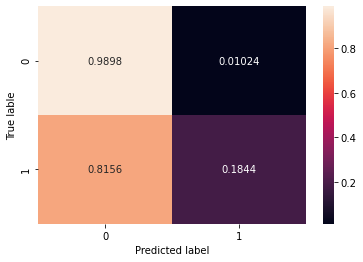

In [50]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix
import seaborn as sns
from matplotlib import pyplot as plt

hd_model = LogisticRegression(C=0.001619402758818777, max_iter=400).fit(x_train, y_train)

# calculate predicted values
y_predict = hd_model.predict(x_train)

#calculate confussion matrix

cm = confusion_matrix(y_train, y_predict)
cm_norm = cm/cm.sum(axis=1).reshape(-1,1)
sns.heatmap(cm_norm, annot=True, fmt=".4")
plt.ylabel('True lable')
plt.xlabel('Predicted label')

In [55]:
from sklearn.metrics import classification_report

print("Classification report for SKLeran best model")
print(classification_report(y_train, y_predict))

Classification report for SKLeran best model
              precision    recall  f1-score   support

           0       0.91      0.99      0.95     21974
           1       0.69      0.18      0.29      2738

    accuracy                           0.90     24712
   macro avg       0.80      0.59      0.62     24712
weighted avg       0.88      0.90      0.87     24712



In [14]:
cpu_cluster.delete()

Current provisioning state of AmlCompute is "Deleting"

